# One Outlier (Section 4.1)

This file contains an experiment identifying a single influential point that can cause a sign flip, which AMIP fails to detect.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import linear_regression
from linear_regression import LinearRegression
import algorithms
import gurobipy as gp
from gurobipy import GRB
import postprocessing

In [2]:
np.random.seed(0)

# Generate Data
num_observations_pop_1 = 1
num_observations_pop_2 = 1000

# Generate the X values.
mean_pop_1 = np.array([1e6])
mean_pop_2 = np.array([0])
vars_pop_1 = np.array([[0]])
vars_pop_2 = [[1]]
x1 = np.random.multivariate_normal(mean_pop_1, vars_pop_1, num_observations_pop_1)
x2 = np.random.multivariate_normal(mean_pop_2, vars_pop_2, num_observations_pop_2)

x = np.append(x1, x2, axis=0) 
x1_0 = [pt[0] for pt in x1]
x2_0 = [pt[0] for pt in x2]

## Generate Data (w intercept).

In [23]:
np.random.seed(0)

# Generate Data
num_observations_pop_1 = 1
num_observations_pop_2 = 1000

# Generate the X values.
mean_pop_1 = np.array([1e6])
mean_pop_2 = np.array([0])
vars_pop_1 = np.array([[0]])
vars_pop_2 = [[1]]
x1 = np.random.multivariate_normal(mean_pop_1, vars_pop_1, num_observations_pop_1)
x2 = np.random.multivariate_normal(mean_pop_2, vars_pop_2, num_observations_pop_2)

x = np.append(x1, x2, axis=0) 
x1_0 = [pt[0] for pt in x1]
x2_0 = [pt[0] for pt in x2] # picks out first column.

# Add an intercept term.
df = pd.DataFrame(x)
df.insert(0, 'Ones', 1)
arr = df.values
x = arr
x1 = x[:1]
x2 = x[1:]

# Generating the Y values.
y1 = [1e6]

epsilon2 = np.random.normal(0, 1, num_observations_pop_2) # eps is the variance of the noise distribution.
slope = -1
y2 = []
for i in range(num_observations_pop_2):
    y2.append(slope*x2_0[i] + epsilon2[i]) # change here to add residual noise.

y = np.concatenate([y1, y2], axis=0)
# y

## (Option to) Generate data without intercept (i.e., w.o. an all-1's column).

In [ ]:
np.random.seed(0)

# Generate Data
num_observations_pop_1 = 1
num_observations_pop_2 = 1000

# Generate the X values.
mean_pop_1 = np.array([1e6])
mean_pop_2 = np.array([0])
vars_pop_1 = np.array([[0]])
vars_pop_2 = [[1]]
x1 = np.random.multivariate_normal(mean_pop_1, vars_pop_1, num_observations_pop_1)
x2 = np.random.multivariate_normal(mean_pop_2, vars_pop_2, num_observations_pop_2)

x = np.append(x1, x2, axis=0)
print(x)
x1 = x[:1]
x2 = x[1:]

# Add an intercept term.
# df = pd.DataFrame(x)
# df.insert(0, 'Ones', 1)
# arr = df.values
# x = arr

# Flatten x for ease of indexing.
x1_0 = x1.flatten()
x2_0 = x2.flatten()

# Generating the Y values.
y1 = [1e6]

epsilon2 = np.random.normal(0, 1, num_observations_pop_2) # eps is the variance of the noise distribution.
slope = -1
intercept = 0
y2 = []
for i in range(num_observations_pop_2):
    y2.append(slope*x2_0[i] + intercept + epsilon2[i]) # change here to add residual noise.

y = np.concatenate([y1, y2], axis=0)
y

[[ 1.00000000e+06]
 [ 4.00157208e-01]
 [ 9.78737984e-01]
 ...
 [-1.14761094e+00]
 [-3.58114075e-01]
 [ 5.55962680e-01]]


array([ 1.00000000e+06,  4.92316679e-01, -1.40105281e+00, ...,
        5.70952564e-03, -9.52856295e-01, -2.08888373e+00])

## Model Fitting

Fit the data using OLS regression.

In [24]:
lr = LinearRegression(x=x.T, y=y)
lr.fit()
modified_lr = LinearRegression(x=x[1:,:].T, y=y2)
modified_lr.fit()
print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}\n"
    f"Estimated beta1 pop B: {modified_lr.beta[1]}"
)

Estimated beta1 with full dataset: 0.9999998935657151
Estimated beta1 pop B: -1.0329686114061063


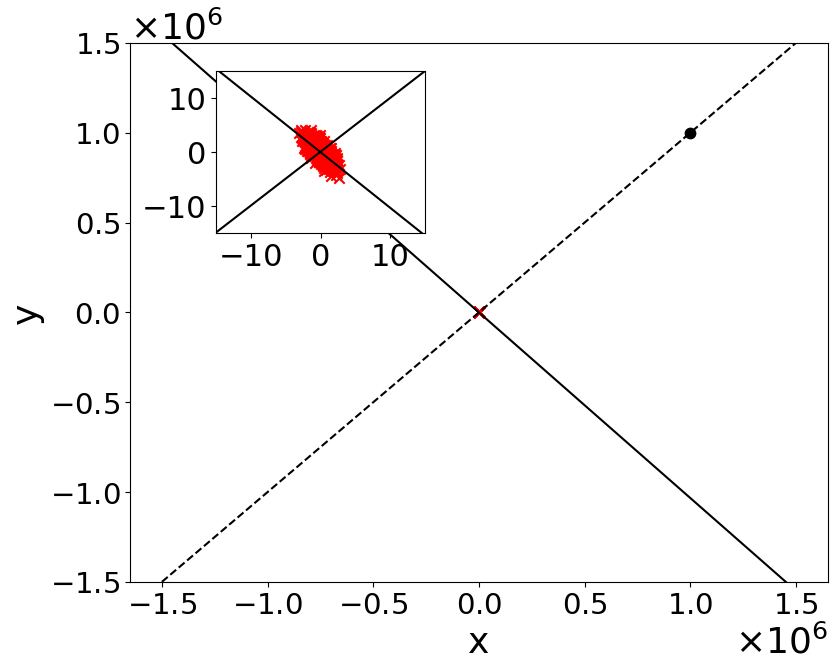

In [25]:
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.figure(figsize=(9, 7))

x_values = np.linspace(-1.5e6, 1.5e6, 100)
y_values_full = lr.beta[1] * x_values + lr.beta[0]
y_value_red_crosses = modified_lr.beta[1] * x_values + modified_lr.beta[0]

plt.plot(x_values, y_values_full, color='black', linestyle='--') 
plt.plot(x_values, y_value_red_crosses, color='black')
plt.scatter(x[0,1], y1, marker='o', color='black', label='Pop. A', s=56)
plt.scatter(x[1:,1], y2, marker='x', color='r', label='Pop. B', s=56)

plt.ylim(-1.5e6, 1.5e6)

plt.xlabel('x', fontsize=26) 
plt.ylabel('y', fontsize=26)

plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.gca().yaxis.get_offset_text().set_fontsize(26)
plt.gca().xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.gca().xaxis.get_offset_text().set_fontsize(26)

 # plt.legend(fontsize=22) # 16

# Create inset of the red crosses.
x_values_inset = np.linspace(-1.5e6, 1.5e6, 100)
y_values_full_inset = lr.beta[1] * x_values_inset + lr.beta[0]
y_value_red_crosses_inset = modified_lr.beta[1] * x_values_inset + modified_lr.beta[0]
ax_inset = inset_axes(plt.gca(), width="30%", height="30%", loc='upper left', bbox_to_anchor=(0.113, -0.040, 1.0, 1), bbox_transform=plt.gca().transAxes)
ax_inset.plot(x_values_inset, y_values_full_inset, color='black') 
ax_inset.plot(x_values_inset, y_value_red_crosses_inset, color='black')
ax_inset.scatter(x[0, 1], y1, marker='o', color='black', s=56)
ax_inset.scatter(x[1:, 1], y2, marker='x', color='r', s=56)
ax_inset.set_xlim(-1.5e1, 1.5e1)  
ax_inset.set_ylim(-1.5e1, 1.5e1)
ax_inset.tick_params(axis='both', which='major', labelsize=22) # 12
ax_inset.tick_params(axis='both', which='minor', labelsize=22)
# set ticks to scientific notation
ax_inset.yaxis.get_offset_text().set_fontsize(12)
ax_inset.xaxis.get_offset_text().set_fontsize(12)

# plt.savefig('one_outlier_example_10.pdf')
plt.show()

## Net Approx. Algorithm

In [26]:
Xnet = np.zeros((x.shape[0],x.shape[1]))
Xnet[:,0] =  x[:,1]
Xnet[:,1] =  x[:,0]

In [27]:
n_sumwstar, wstar = algorithms.net_algorithm(Xnet,y,1000)

In [29]:
print(f"Number of points needed to be removed to zero-out the OLS solution: {n_sumwstar}")
# find the indices of the MIS.
alphaN = 1
mis_inds = np.argsort(wstar)[:alphaN]
mis_inds

Number of points needed to be removed to zero-out the OLS solution: 1001.0


array([0])

## Gurobi [FH23]

In [9]:
model_objbound_frac, model_objval_frac, weights_frac, model_frac = algorithms.solve_regression_fractional(x,y, intercept=False,time_limit=30, warm_start=None, verbose=True,
                               greater_one_constraint=False, pairs=None)
weights_from_fractional_gurobi = np.array([w.X for w in weights_frac])

set residual constraints
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 30
start solving
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 21.6.0 21H1320)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  30
NonConvex  2

Optimize a model with 2002 rows, 1002 columns and 2002 nonzeros
Model fingerprint: 0xdb21fc8f
Model has 2 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e-03, 1e+06]
  QLMatrix range   [7e-04, 1e+12]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2002 rows and 0 columns

Continuous model is non-convex -- solving as a MIP

Found heuristic solution: objective -0.0000000
Presolve removed 2002 rows and 0 columns
P

In [10]:
model_objbound, model_objval, weights, model = algorithms.solve_regression_integral(x,y, intercept=True,time_limit=30, warm_start=weights_from_fractional_gurobi, verbose=True, #beta_sign=1,
                                warm_start_ub=None, pairs = None)
integer_weights = np.array([w.X for w in weights])

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 30
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 21.6.0 21H1320)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  30
NonConvex  2

Optimize a model with 1 rows, 1004 columns and 1 nonzeros
Model fingerprint: 0x8d93909a
Model has 3 quadratic constraints
Variable types: 3 continuous, 1001 integer (1001 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [2e-06, 1e+12]
  QLMatrix range   [7e-04, 1e+12]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

User MIP start produced solution with objective 1000 (0.01s)
Loaded user MIP start with objective 1000

Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolv

In [11]:
# select the indices of the points with weight 0.
indices_to_remove = np.where(integer_weights == 0)[0]
indices_to_remove

array([0])

## Gurobi (no warm start)

In [12]:
model_objbound, model_objval, weights, model = algorithms.solve_regression_integral(x,y, intercept=True,time_limit=30, warm_start=None, verbose=True, #beta_sign=1,
                            warm_start_ub=None, pairs = None)

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 30
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 21.6.0 21H1320)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  30
NonConvex  2

Optimize a model with 1 rows, 1004 columns and 1 nonzeros
Model fingerprint: 0x92d05d0c
Model has 3 quadratic constraints
Variable types: 3 continuous, 1001 integer (1001 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [2e-06, 1e+12]
  QLMatrix range   [7e-04, 1e+12]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective -0.0000000
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 6008 rows, 10013 columns, 23022 nonzeros
Presolved mod

In [13]:
integer_weights = np.array([w.X for w in weights])

In [14]:
# select the indices of the points with weight 0.
indices_to_remove = np.where(integer_weights == 0)[0]
indices_to_remove

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   22,
         23,   24,   25,   26,   27,   28,   29,   30,   31,   32,   33,
         34,   35,   36,   37,   38,   39,   40,   41,   42,   43,   44,
         45,   46,   47,   48,   49,   50,   51,   52,   53,   54,   55,
         56,   57,   58,   59,   60,   61,   62,   63,   64,   65,   66,
         67,   68,   69,   70,   71,   72,   73,   74,   75,   76,   77,
         78,   79,   80,   81,   82,   83,   84,   85,   86,   87,   88,
         89,   90,   91,   92,   93,   94,   95,   96,   97,   98,   99,
        100,  101,  102,  103,  104,  105,  106,  107,  108,  109,  110,
        111,  112,  113,  114,  115,  116,  117,  118,  119,  120,  121,
        122,  123,  124,  125,  126,  127,  128,  129,  130,  131,  132,
        133,  134,  135,  136,  137,  138,  139,  140,  141,  142,  143,
        144,  145,  146,  147,  148,  149,  150,  1

In [15]:
len(indices_to_remove)

993

## Checking each term in Prop C.2 (leverage and residual)

## Checking s and t.

In [ ]:
# dataset generation.
np.random.seed(0)

# Generate Data
num_observations_pop_1 = 1
num_observations_pop_2 = 1000

# Generate the X values.
# mean_pop_1 = np.array([1e10, 0, 0])
# mean_pop_2 = np.array([0, 0, 0])
# vars_pop_1 = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0]])
# vars_pop_2 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
mean_pop_1 = np.array([1e10])
mean_pop_2 = np.array([0])
vars_pop_1 = np.array([[0]])
vars_pop_2 = np.array([[1]])

x1 = np.random.multivariate_normal(mean_pop_1, vars_pop_1, num_observations_pop_1)
x2 = np.random.multivariate_normal(mean_pop_2, vars_pop_2, num_observations_pop_2)

x = np.append(x1, x2, axis=0)
print(x)
x1 = x[:1]
x2 = x[1:]

# Flatten x for ease of indexing.
x1_0 = x1.flatten()
x2_0 = x2.flatten()

# Generating the Y values.
y1 = [1e10]

epsilon2 = np.random.normal(0, 1, num_observations_pop_2) # eps is the variance of the noise distribution.
slope = -1
intercept = 0
y2 = []
for i in range(num_observations_pop_2):
    y2.append(slope*x2_0[i] + intercept + epsilon2[i]) # change here to add residual noise.

y = np.concatenate([y1, y2], axis=0)
y

[[ 1.00000000e+10]
 [ 4.00157208e-01]
 [ 9.78737984e-01]
 ...
 [-1.14761094e+00]
 [-3.58114075e-01]
 [ 5.55962680e-01]]


array([ 1.00000000e+10,  4.92316679e-01, -1.40105281e+00, ...,
        5.70952564e-03, -9.52856295e-01, -2.08888373e+00])

In [ ]:
Lambda = 1e2
xj = np.array([1]).reshape(-1, 1)
yj = np.array([4]).reshape(-1, 1)
v = np.array([1]).reshape(-1, 1)
e = np.array([1]).reshape(-1, 1)
xi = np.array([Lambda]).reshape(-1, 1)
yi = np.array([Lambda]).reshape(-1, 1)
Ainv = np.linalg.inv(x2.T @ x2)
Bi = np.dot(y2, x2).reshape(-1, 1)

s = v.T @ Ainv @ v * e.T @ Ainv @ xj - e.T @ Ainv @ v @ v.T @ Ainv @ xj
print(f'value of s: {s}')
t = yj * v.T @ Ainv @ v - v.T @ Ainv @ xj - Bi.T @ Ainv @ xj * v.T @ Ainv @ v + Bi.T @ Ainv @ v * v.T @ Ainv @ xj
print(f'value of t: {t}')

value of s: [[0.]]
value of t: [[0.00308173]]


### Checking each term in Prop D.2: Influence Function

In [196]:
Lambda = 1e6
xj = np.array([1, 2.697]).reshape(-1, 1)
yj = -4.854
xi = np.array([1, Lambda]).reshape(-1, 1)
v = np.array([1/Lambda, 1]).reshape(-1, 1)
e = np.array([0, 1]).reshape(-1, 1)
Ainv = np.linalg.inv(x2.T @ x2)
Bi = np.dot(y2, x2)

In [197]:
x.T @ x

array([[ 1001.        ,    53.53520284],
       [   53.53520284, 10973.47983971]])

In [198]:
x2.T @ x2 + x1.T @ x1

array([[ 1001.        ,    53.53520284],
       [   53.53520284, 10973.47983971]])

In [199]:
# empirically correct.
print(e.T @ np.linalg.inv(x.T @ x) @ xj)

# end of derivation.
print(Lambda * e.T @ Ainv @ xj / (1 + Lambda**2 * v.T @ Ainv @ v))

[[0.00024096]]
[[2.74346454e-06]]


### Checking the Rate of the Residual Term.

In [209]:
x2tx2inv = np.linalg.inv(x2.T @ x2)
v = np.array([[0, 1]])
v = v.T
v.shape

(2, 1)

In [210]:
et = np.array([[0, 1]])
et.shape

(1, 2)

In [211]:
xtxinv = np.linalg.inv(x.T @ x)
xtxinv.shape

(2, 2)

## Additive and Greedy algorithms.


#### Additive Algorithms.

In [16]:
outlier_df = postprocessing.compute_scores(x, y, lr, True)
outlier_df.head(5)

,x,y,residual,leverage,IF,1Exact,sorted_IF_indices,sorted_1Exact_indices,sorted_IF_scores,sorted_1Exact_scores
0,1.0,1000000.000000,0.001975,1.000,-9.175429e-11,-0.094464,271,0,-0.006846,-0.094464
1,1.0,0.492317,-0.012300,0.001,1.230010e-05,0.000012,589,271,-0.006546,-0.006853
2,1.0,-1.401053,-2.484250,0.001,2.484248e-03,0.002487,427,589,-0.006353,-0.006552
3,1.0,-2.136179,-4.481532,0.001,4.481521e-03,0.004486,735,427,-0.006220,-0.006360
4,1.0,-1.639505,-3.611522,0.001,3.611515e-03,0.003615,20,735,-0.006017,-0.006226


if we consider the 1-outlier setting with no intercept, and (x,y) = (1e10, 1e10), then we find that for (x1, y1), the residual is zero while the leverage is 1e0, and for (x2, y2), the residual ranges from 1e-2 to 1 and the leverage ranges from 1e-21 to 1e-20. thus, the influence score for (x2, y2) is smaller.

- at x = y = 1e3 AMIP fails in type 1 but not type 2 (correct ordering).
- at x = y = 1e6 AMIP fails in type 1 and type 2 (incorrect ordering).

In [18]:
print(f'The AMIP approximation of the refit is {round(lr.beta[1] + sum(outlier_df["sorted_IF_scores"][:1]), 4)}.')
print(f'The Add-1Exact for the change induced by dropping the worst-case subset of size at most 1 is {round(lr.beta[1] + sum(outlier_df["sorted_1Exact_scores"][:1]), 4)}.')
print(f'The true change induced by dropping the worst-case subset of size at most 1 is {round((modified_lr.beta[1]), 4)}.')

The AMIP approximation of the refit is 0.9932.
The Add-1Exact for the change induced by dropping the worst-case subset of size at most 1 is 0.9055.
The true change induced by dropping the worst-case subset of size at most 1 is -1.033.


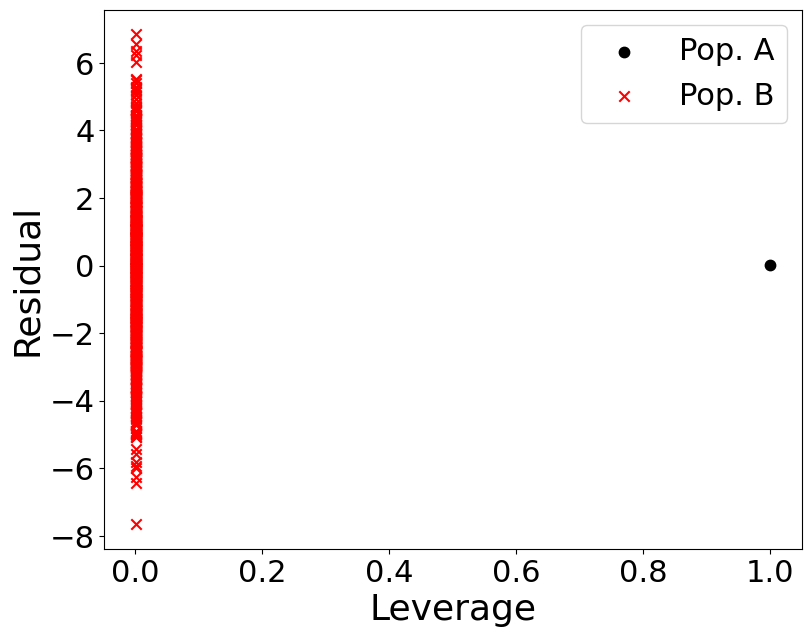

In [14]:
plt.figure(figsize=(9, 7))

plt.scatter(outlier_df['leverage'][:1], outlier_df['residual'][:1], marker='o', color='black', label='Pop. A', s=56)
plt.scatter(outlier_df['leverage'][1:], outlier_df['residual'][1:], marker='x', color='r', label='Pop. B', s=56)

plt.xlabel('Leverage', fontsize=26) 
plt.ylabel('Residual', fontsize=26)

plt.xticks(fontsize=22) 
plt.yticks(fontsize=22)

plt.legend(fontsize=22)
# plt.savefig('one_outlier_levresid.pdf', bbox_inches='tight')
plt.show()

#### Greedy Algorithms.

Results can be read from the additive approximations for the setting of removing one data point.

## Code for Creating the Table and Leverage Plot in Appendix.

In [62]:
### Helpers.
def plot_regression(x, y, x1, y1, x2, y2):
    ## X vs Y
    plt.scatter(x1[0], y1, marker='o', color='black', label='Pop. A', s=56)
    plt.scatter(x2[0], y2, marker='x', color='r', label='Pop. B', s=56)
    # plt.title('One-dimensional Example')
    
    plt.xlabel('x', fontsize=22)  # Larger font for x-axis label
    plt.ylabel('y', fontsize=22)  # Larger font for y-axis label
    
    # Set the size of tick marks
    plt.xticks(fontsize=12)  # Larger ticks for x-axis
    plt.yticks(fontsize=12)  # Larger ticks for y-axis
    
    plt.legend(fontsize=22)

    plt.show()

    x = x.T
    lr = LinearRegression(x=x.T, y=y)
    lr.fit()
    print(
        f"Beta with full dataset: {lr.beta[0]}"
    )

    # Dropping just x1 should change the analysis (based on data generating process)
    modified_lr = LinearRegression(x=x2, y=y2) # Drop Pop_1 data
    modified_lr.fit()
    print(
        f"Beta with subset dropped: {modified_lr.beta[0]}"
    )
    
    return lr

def make_df(lr):
    # III. Compute influence scores and Newton scores for first coefficient.
    scores = -lr.influence_scores()[0] # after adding an intercept term, take the scores of coefficient 1.
    newton_scores = -lr.one_step_newton()[0]

    # sort indices in ascending order (influence scores are negative, so the largest magnitude scores appear first.)
    inds = np.argsort(scores)
    # print("inds", inds[:10])
    original_inds = inds # original_inds

    newton_inds = np.argsort(newton_scores)
    # print("newton inds", newton_inds[:10])
    original_newton_inds = newton_inds 

    # sort scores.
    sorted_scores = scores[inds]
    # print("sorted_scores", sorted(scores)[:10])
    original_sorted_scores = sorted_scores

    sorted_newton_scores = newton_scores[inds]
    # print("sorted_newton_scores", sorted_newton_scores[:10])
    original_sorted_newton_scores = sorted_newton_scores
    
    # influential point
    outlier_x = np.squeeze(x1[0][0])
    outlier_y = np.squeeze(y1[0][0])
    print(f"outlier_x: {outlier_x}")
    print(f"outlier_y: {outlier_y}")
    # residuals
    residuals = lr.residual()
    # print(f"outlier_residual: {round(residuals[0], 4)}")
    # leverages
    leverages = lr.leverage_scores()
    # print(f"outlier_leverage: {round(leverages[0], 4)}")
    # schmeverage e1
    shmeverage_e1 = lr.schmeverage_scores([(1,)])
    # print(f'schmeverage_e1: {round(shmeverage_e1[0], 4)}')
    # Compute influence functions for first coefficient
    scores = -lr.influence_scores()[0] # effect of removing a data point on beta1.
    # print("outlier influence score:", round(scores[0], 4))
    leverage_correction = 1 / (1 - leverages)


    # create a df with residuals, leverages, and coordinates.
    orig_df = pd.DataFrame({'x': x.flatten(), 'y':y.flatten(),
                            'residual': residuals, 'schmeverage': shmeverage_e1,
                            'leverage': leverages, 'leverage_correction': leverage_correction,
                            'influence': scores, 'newton': newton_scores})
    
    return orig_df